# Natural Language Processing: AI Detection using Machine Learning Techniques

**Group Members: Nathanielle, Rishika, Michelle, Ying Lin**

**Research Question** : How can AI be used to detect if a political article is real or AI-generated? What keywords are significant in differentiating between a real and AI-generated article?

## Introduction
insert stuff here - context of rise of AI and significance of analysis (if need inspo, look at ying's branch???)

## Data Description


Feel free to make edits - Ying
For our statistical analysis, we will be using the GoodNews dataset, which was created by Ali Fukan Biten, Lluis Gomez, Marcal Rusiñol, and Dimosthenis Karatzas for their research on image captioning. The GoodNews dataset is composed of articles from New York Times from 2010 and 2018 (Biten, Gomez, Rusiñol, Karatzas 3).

The widespread integration and use of generative AI tools such as ChatGPT and Microsoft Copilot posed the initial concern that human-generated text used these tools, which would lead to a confounding factor that we can't measure and analyze. Generative AI rose in popularity in approximately 2022, as marked by the release of ChatGPT in November 2022 and the sudden spike in market value since 2022 (Bloomberg 2023). It is unlikely that AI used used in the creation of New York Times articles because Generative AI was in experimental phase and New York Times authors likely did not have significant evidence that proved the efficiacy of Generative AI.

https://www.bloomberg.com/company/press/generative-ai-to-become-a-1-3-trillion-


## Data Cleaning

In [21]:
import pandas as pd
import numpy as np
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from collections import defaultdict
from sklearn import metrics
from nltk.stem import WordNetLemmatizer
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_curve, auc
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn.svm import LinearSVC
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [4]:
news_df = pd.read_csv("news_dataset.csv")
print (f"The shape of the original dataframe is {news_df.shape}")
news_df.head()

The shape of the original dataframe is (64000, 2)


,Labels,Articles
0,fake,A longtime champion of the homeless and batter...
1,fake,"Tucked away in the Marais, two warring groups ..."
2,fake,There are plenty of things that can impede wom...
3,fake,"New York City is home to more than 2,500 tiny ..."
4,fake,A man wearing a hat emblazoned with the words ...


In [15]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('omw-1.4')
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /Users/makem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/makem/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/makem/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/makem/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/makem/nltk_data...


In [6]:
# Converted all articles to lower case
news_df['Articles'] = [article.lower() for article in news_df["Articles"]]
# Filter the articles to only political articles
filtered_df = news_df[news_df["Articles"].str.contains(""" election|
             campaign| vote| ballot| voting| polling| candidate| nominee| politician|
             leader| opposition| incumbent| poll| polling| approval rating|
             electorate| conservative| liberal| democrat| republican| left-wing|
             right-wing| centrist| far-right| far-left| populist|
             governor| mayor| senator| representative| joe biden| bernie sanders| 
             elizabeth warren| pete buttigieg| andrew yang| tulsi gabbard| 
             kamala harris""", case=False)]

# Clean the labels column into fake (AI generated) versus not fake (human generated)
filtered_df.reset_index(drop=True, inplace=True)
filtered_df.loc[filtered_df["Labels"] == "fake", "Labels"] = 1
filtered_df.loc[filtered_df["Labels"] == "real", "Labels"] = 0
filtered_df = filtered_df.rename(columns={'Labels': 'Fake', 'Articles':'Article'})
filtered_df["Fake"] = filtered_df["Fake"].astype(int)
print(f'The shape of the filtered data frame is: {filtered_df.shape}')
print (f"Number of real articles {filtered_df.shape[0] - sum(filtered_df['Fake'])}")
print (f"Number of AI generated articles {sum(filtered_df['Fake'])}")

The shape of the filtered data frame is: (17278, 2)
Number of real articles 8618
Number of AI generated articles 8660


In [13]:
unprocessed_ai = pd.DataFrame(filtered_df[filtered_df['Fake']==1])
unprocessed_real = pd.DataFrame(filtered_df[filtered_df['Fake']==0])
fake_unprocessed_sample = unprocessed_ai.sample(5000, random_state= 2950)
real_unprocessed_sample = unprocessed_real.sample(5000, random_state= 2950)

In [16]:
def text_preprocessing(article):
    """
    article(string): Text to be cleaned for text analysis
    A function that accepts article and removes the punctuation, pronouns,
    and commonly used words that don't provide additional information such as 
    'the', 'a', etc.
    """
    # Remove punctuation
    article = ''.join([char for char in article if char not in string.punctuation])
    # Lemmatization of all non-stop words
    article = ' '.join([lemmatizer.lemmatize(word) for word in article.split() 
                        if word.isalpha() and word not in stop_words])
    
    return article

filtered_df["Cleaned_Article"] = filtered_df["Article"].apply(text_preprocessing)
filtered_df["Cleaned_Article"] = filtered_df["Cleaned_Article"].astype("string")


In [17]:
ai_articles = pd.DataFrame(filtered_df[filtered_df['Fake']==1])
real_articles = pd.DataFrame(filtered_df[filtered_df['Fake']==0])

fake_processed_sample = ai_articles.sample(n=5000, random_state= 2950)
real_processed_sample = real_articles.sample(n=5000, random_state= 2950)
merged_df = pd.concat([fake_processed_sample, real_processed_sample])

## Exploratory Data Analysis

In [ ]:
processed_merged_df = pd.concat([real_processed_sample, fake_processed_sample])
processed_merged_df.reset_index(inplace = True, drop = True)
joint_1000text = " ".join(article for article in real_processed_sample["Cleaned_Article"].sample(1000, random_state= 2950))

stopwords = set(STOPWORDS)
# add additional filtering to provide more insightful information
stopwords.update(["said", "would", "time", "year", "one", "city", "like", "mr", "new", "york", "times"])

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                max_words= 200,
                min_font_size = 10).generate(joint_1000text)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.title("Word Cloud for A Randomized Sample of 1000 Articles (Human Generated)")
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [ ]:
joint_1000text = " ".join(article for article in fake_processed_sample["Cleaned_Article"].sample(1000, random_state= 2950))

stopwords = set(STOPWORDS)
# add additional filtering to provide more insightful information
stopwords.update(["said", "would", "time", "year", "one", "city", "like", "mr", "new", "york", "times"])

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                max_words= 200,
                min_font_size = 10).generate(joint_1000text)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.title("Word Cloud for A Randomized Sample of 1000 Articles (AI Generated)")
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

#### Topic Analysis of Articles

In [ ]:
def get_top_ngrams(text_series, ngram_range=(5, 5), top_n=5):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    ngram_matrix = vectorizer.fit_transform(text_series)
    ngram_counts = np.asarray(ngram_matrix.sum(axis=0)).flatten()

    ngram_terms = vectorizer.get_feature_names_out()

    ngram_freq = Counter(dict(zip(ngram_terms, ngram_counts)))
    top_ngrams = ngram_freq.most_common(top_n)

    return top_ngrams

# Separate the articles
real_articles = filtered_df[filtered_df['Fake'] == 0]['Cleaned_Article']
fake_articles = filtered_df[filtered_df['Fake'] == 1]['Cleaned_Article']

# Retrieve the top 5-gram from  REAL articles and fake articles
# Look into ngram range
top_five_grams_real = get_top_ngrams(real_articles, ngram_range=(5, 5), top_n=5)
top_five_grams_fake = get_top_ngrams(fake_articles, ngram_range=(5, 5), top_n=5)

# Unzipping
real_ngram_labels, real_ngram_values = zip(*top_five_grams_real)
fake_ngram_labels, fake_ngram_values = zip(*top_five_grams_fake)

#Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=list(real_ngram_values), y=list(real_ngram_labels), palette='Blues')
plt.title('Top 5-grams in REAL Human-written Articles')
plt.xlabel('Frequency')
plt.ylabel('5-gram')
plt.subplot(1, 2, 2)
sns.barplot(x=list(fake_ngram_values), y=list(fake_ngram_labels), palette='Reds')
plt.title('Top 5-grams in FAKE AI-generated Articles')
plt.xlabel('Frequency')
plt.ylabel('5-gram')

# Graph Layout
plt.tight_layout()
plt.show()

#### Length difference between AI generated text and human text

In [ ]:
fake_unprocessed_sample["Word_Count"] = fake_unprocessed_sample["Article"].apply(lambda n: len(n.split()))
real_unprocessed_sample["Word_Count"] = real_unprocessed_sample["Article"].apply(lambda n: len(n.split()))
print ("In the original data set: ")
print(f"""On average, AI-Generated articles has approximately 
      {fake_unprocessed_sample['Word_Count'].mean():.2f} words per article.""")
print(f"""On average, non AI-Generated articles has approximately 
      {real_unprocessed_sample['Word_Count'].mean():.2f} words per article.""")
print ("\nAfter lemmatization and removing of stop words: ")
fake_processed_sample["Word_Count"] = fake_processed_sample["Cleaned_Article"].apply(lambda n: len(n.split()))
real_processed_sample["Word_Count"] = real_processed_sample["Cleaned_Article"].apply(lambda n: len(n.split()))
print(f"""On average, AI-Generated articles has approximately 
      {fake_processed_sample['Word_Count'].mean():.2f} words per article.""")
print(f"""On average, non AI-Generated articles has approximately 
      {real_processed_sample['Word_Count'].mean():.2f} words per article.""")

## Model Building

#### Logistic Regression Analysis with Bag of Words

In [18]:
vectorizer = TfidfVectorizer(min_df = 10)
X = vectorizer.fit_transform(merged_df["Cleaned_Article"]).toarray()
y = merged_df["Fake"]  # 1 = fake, 0 = real
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2950)
print (f"""The shape of the train sample is {X_train.shape} and the shape 
       for the test sample is {X_test.shape}""")

The shape of the train sample is (8000, 15382) and the shape 
       for the test sample is (2000, 15382)


In [19]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print accuracy and classification report
print(f'Accuracy: {accuracy * 100:.2f}%')
print('Classification Report:')
print(report)

Accuracy: 88.70%
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1025
           1       0.88      0.89      0.88       975

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000



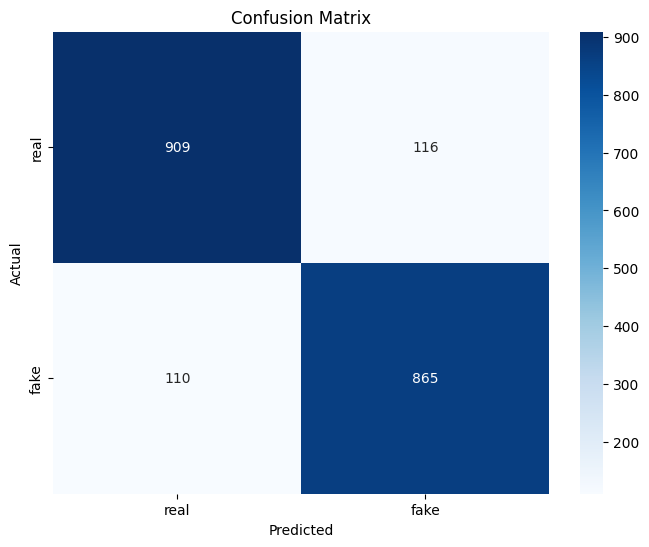

In [20]:
# Confusion Matrix
# this is used to see the proportion of correct identifications to errors in the form of false negatives and false positives
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['real', 'fake'], yticklabels=['real', 'fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

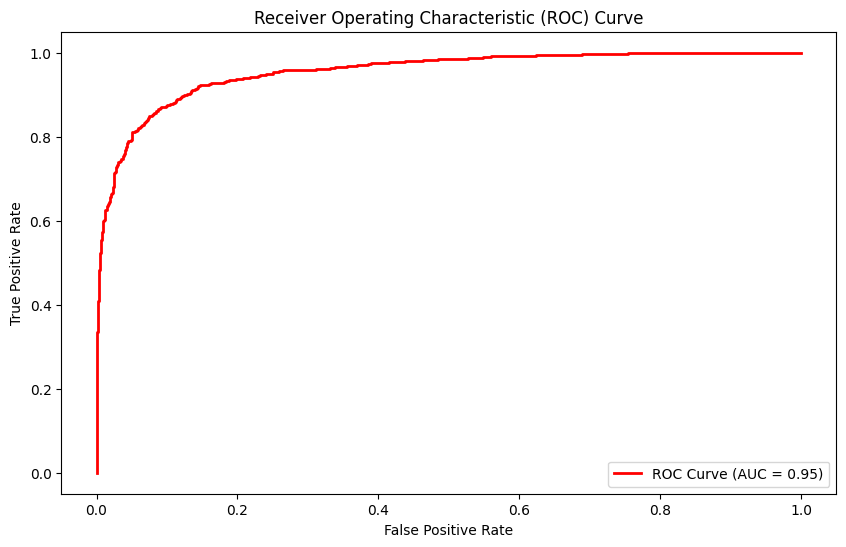

In [24]:
# Plotting the Receiver Operating Characteristic (ROC) curve
# this curve is used to show the specificity of our data by showing the incorrect classification of negatives with the false positive rate
# and the sensitivity of the data with the true positive rate

# calculating the probability of belonging to the AI class (positive class) of news articles
y_prob = lr.predict_proba(X_test)[:,1]

# calculating the false positive rate and true positive rate from test data and predictions at various points
fpr, tpr, _ = roc_curve(y_test, y_prob)

# calculating the area under the curve (AUC) to summarize model performance
roc_auc = auc(fpr, tpr)

# plot the ROC curve for visuals
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

#### Random Forest (n=100) Classification

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
y_prob = rf_classifier.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [ ]:
individual_tree = rf_classifier.estimators_[0]

dot_data = export_graphviz(
    individual_tree,
    feature_names=vectorizer.get_feature_names_out(),
    class_names=['Real', 'Fake'],
    rounded=True,
    filled=True
)

graph = graphviz.Source(dot_data)
graph.render('individual_tree', view=True)
graph

### CNN Classification

In [ ]:
clf = LinearSVC()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

### KMeans Clustering

In [ ]:
# True labels for evaluation
labels = processed_merged_df["Fake"].tolist()
evaluations = []
evaluations_std = []

# Define the evaluation function
def fit_and_evaluate(km, X, labels, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name
    scores = defaultdict(list)
    
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        km.fit(X)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(metrics.adjusted_rand_score(labels, km.labels_))
        scores["Silhouette Coefficient"].append(metrics.silhouette_score(X, km.labels_, sample_size=2000))
    
    evaluation = {"estimator": name}
    evaluation_std = {"estimator": name}
    
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

Homogeneity: Measures if each cluster contains only members of a single class. A low score (close to 0) indicates that the clusters are not homogeneous, meaning that the clusters contain a mix of different classes.

Completeness: Measures if all members of a given class are assigned to the same cluster. A low score (close to 0) suggests that the members of each class are spread across multiple clusters, indicating poor clustering performance.

V-measure: The harmonic mean of homogeneity and completeness. A low V-measure indicates that both homogeneity and completeness are low, reflecting poor overall clustering quality.

Adjusted Rand-Index: Measures the similarity between the true labels and the clustering labels, adjusted for chance. A low score (close to 0) indicates that the clustering results are not much better than random assignment.

Silhouette Coefficient: Measures how similar an object is to its own cluster compared to other clusters. A low score (close to 0) suggests that the clusters are not well-separated, and the data points are not well-clustered.

In [ ]:
kmeans = KMeans(n_clusters=2)
fit_and_evaluate(kmeans, X, labels=labels, name="KMeans on tf-idf vectors")

As shown above, when it's set to two clusters and initialized using the greedy kmeans++ and the distribution of the points, it does not perform well. The purity of resulting clusters are low and the algorthm is not accurately clustering the article. To address this, possible steps could be to tune the parameters and use principal component analysis to reduce the amount of dimensions.

First, I will experiment with the initialization of the centriods and setting it to random, where the inital centroids will be randomly selected.

In [ ]:
kmeans = KMeans(n_clusters=2, init = "random")
fit_and_evaluate(kmeans, X, labels=labels, name="KMeans on tf-idf vectors")

From the above values, we can see that randomly initializing the centroid did help with increasing the evaluation metrics. Using the random centriod initialization method, how would the changing the number of independent runs change this? When using a random centriod initialization method, the algorithm runs 10 times and the best output is returned. Would increasing the amount of times the algorithm is run enhance the performance?

From the data exploration section, we see that there is an difference between article length and the source of the article (human generated or AI generated). Is this difference significant?

In [ ]:
processed_merged_df["Article_Length"] = processed_merged_df["Cleaned_Article"].apply(lambda n: len(n.split()))
Xtrain_len, Xtest_len, ytrain_len, ytest_len = train_test_split(
    processed_merged_df["Article_Length"].values.reshape(-1, 1), 
    processed_merged_df["Fake"], 
    test_size=0.3, 
    random_state=2950
)

Xtrain_sm = sm.add_constant(Xtrain_len)
logit_model = sm.Logit(ytrain_len, Xtrain_sm).fit()
print(logit_model.summary())

In [ ]:
Xtest_sm = sm.add_constant(Xtest_len)
ytest_len_prob = logit_model.predict(Xtest_sm)
ytest_len_pred = [1 if prob > 0.65 else 0 for prob in ytest_len_prob]
test_scores = classification_report(ytest_len, ytest_len_pred,zero_division=0)
print (test_scores)

Through the classification report, we can observe that the model performs well in identifying AI-generated articles as shown by the high recall for AI-generated text but struggles significantly with human-generated articles as demonstrated by the scores. 

The overall accuracy is 48%, indicating that the model correctly predicts the class for 48% of the articles. This means that if one uses only length to infer if an article is AI-generated or not, it performs worst than randomly guessing.

In [ ]:
X_combined = pd.concat([pd.DataFrame(X), 
                        processed_merged_df["Article_Length"].reset_index(drop=True)], axis=1)
X_combined.columns = X_combined.columns.astype(str)
fit_and_evaluate(kmeans, X_combined, labels=labels, name="KMeans on tf-idf vectors")

Although still low, we can see that adding article length significantly increased the silhouette coefficient, which reflect the defineness of clusters and did increase the other metrics such as homogeneity and completeness.

From the EDA section, we see that the AI-generated article tend to use the phrase "read the full story at" while the human-generated article did not.

## Analysis and Conclusion

## Data Limitation

## Future Implications

## Sources